In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 744.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

In [9]:
dataset = load_dataset("/content/gdrive/MyDrive/Colab Notebooks/LLMs/Datasets/SlimOrca", split="train", num_proc=4)

Setting num_proc from 4 back to 1 for the train split to disable multiprocessing as it only contains one shard.


Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
tokenizer = AutoTokenizer.from_pretrained("/content/gdrive/MyDrive/Colab Notebooks/LLMs/Models/phi-2", add_eos_token=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
class SpecialTokens:
    conversation_start_token: str = "<|im_start|>"
    conversation_end_token: str = "<|im_end|>"
    pad_token: str = "<|pad|>"
    system_token = "<|system|>"
    user_token = "<|user|>"
    assistant_token = "<|assistant|>"


chat_format_tokens = SpecialTokens

# Add special tokens to the tokenizer
tokenizer.add_special_tokens(
    {
        "additional_special_tokens": [
            chat_format_tokens.conversation_start_token,
            chat_format_tokens.conversation_end_token,
            chat_format_tokens.pad_token,
            chat_format_tokens.system_token,
            chat_format_tokens.user_token,
            chat_format_tokens.assistant_token
        ]
    }
)

CHAT_TEMPLATE = """{% for message in messages %}{{'<|im_start|>' + '<|' + message['role'] + '|>' + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}"""
tokenizer.chat_template = CHAT_TEMPLATE
tokenizer.pad_token = chat_format_tokens.pad_token

In [12]:
messages = [
    {
        "role": "system",
        "content": "Your are a helpful bot who will answer the questions given to you faithfully"
    },
    {
        "role": "user",
        "content": "Hi how are you"
    }
]

tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt")
print(tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True))
print("\n")
print(tokenizer.tokenize(tokenizer.decode(tokenized_chat[0])))

<|im_start|><|system|>
Your are a helpful bot who will answer the questions given to you faithfully<|im_end|>
<|im_start|><|user|>
Hi how are you<|im_end|>



['<|im_start|>', '<|system|>', 'Ċ', 'Your', 'Ġare', 'Ġa', 'Ġhelpful', 'Ġbot', 'Ġwho', 'Ġwill', 'Ġanswer', 'Ġthe', 'Ġquestions', 'Ġgiven', 'Ġto', 'Ġyou', 'Ġfaithfully', '<|im_end|>', 'Ċ', '<|im_start|>', '<|user|>', 'Ċ', 'Hi', 'Ġhow', 'Ġare', 'Ġyou', '<|im_end|>', 'Ċ']


In [ ]:
batched_chat = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt")
print(tokenizer.decode(tokenized_chat[0]))

<|im_start|><|system|>
Your are a helpful bot who will answer the questions given to you faithfully<|im_end|>
<|im_start|><|user|>
Hi how are you<|im_end|>



In [13]:
print(tokenizer.vocab["<|im_start|>"])
print(tokenizer.vocab["<|im_end|>"])
print(tokenizer.vocab["<|system|>"])
print(tokenizer.vocab["<|user|>"])
print(tokenizer.vocab["<|assistant|>"])

50295
50296
50298
50299
50300


In [ ]:
def convert_to_ml_template(example):
  messages = []

  for conversation in example.get("conversations"):
    message = {}
    if(conversation.get("from")=="human"):
      role = "user"
    elif(conversation.get("from")=="gpt"):
      role = "assistant"
    else:
      role = "system"

    message["role"] = role
    message["content"] = conversation.get("value")
    message["weight"] = conversation.get("weight")

    messages.append(message)

  tokenized_chat = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
  return {"text": tokenized_chat}

In [14]:
def convert_to_ml_template_with_eos(example):
  messages = []

  for conversation in example.get("conversations"):
    message = {}
    if(conversation.get("from")=="human"):
      role = "user"
    elif(conversation.get("from")=="gpt"):
      role = "assistant"
    else:
      role = "system"

    message["role"] = role
    message["content"] = conversation.get("value")
    message["weight"] = conversation.get("weight")

    messages.append(message)

  tokenized_ids = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)
  tokenized_ids.append(tokenizer.eos_token_id)
  tokenized_chat = tokenizer.decode(tokenized_ids)
  return {"text": tokenized_chat}

In [ ]:
data_processed = dataset.map(convert_to_ml_template, remove_columns="conversations")

Map:   0%|          | 0/517982 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2181 > 2048). Running this sequence through the model will result in indexing errors


In [16]:
data_processed = dataset.map(convert_to_ml_template_with_eos, remove_columns="conversations")

Map:   0%|          | 0/517982 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2181 > 2048). Running this sequence through the model will result in indexing errors


In [17]:
data_processed[0]

{'text': '<|im_start|><|system|>\nYou are an AI assistant. You will be given a task. You must generate a detailed and long answer.<|im_end|>\n<|im_start|><|user|>\nWrite an article based on this "A man has been charged with murder and attempted murder after a woman and the man she was on a date with were stabbed at a restaurant in Sydney, Australia."<|im_end|>\n<|im_start|><|assistant|>\nTitle: Tragedy Strikes in Sydney: Victims Stabbed during Dinner Date, Suspect Charged with Murder and Attempted Murder\n\nIntroduction\n\nA seemingly ordinary evening took a tragic turn in Sydney, Australia when a romantic dinner date at a local restaurant ended in bloodshed, as a man allegedly attacked a couple, stabbing both victims. Local authorities have charged the suspect with murder and attempted murder in connection with the horrific crime. In this article, we delve into the chilling incident, the suspect, and the impact it has had on the community.\n\nThe Incident\n\nThe alarming event took pl

In [ ]:
data_processed.save_to_disk("/content/gdrive/MyDrive/Colab Notebooks/LLMs/Datasets/SlimOrca-Transformed-tokenized")

Saving the dataset (0/4 shards):   0%|          | 0/517982 [00:00<?, ? examples/s]

In [18]:
data_processed.save_to_disk("/content/gdrive/MyDrive/Colab Notebooks/LLMs/Datasets/SlimOrca-Transformed-with-eos")

Saving the dataset (0/2 shards):   0%|          | 0/517982 [00:00<?, ? examples/s]

517982
Max: 39708
Min: 140
Mean: 1823.2334212385758


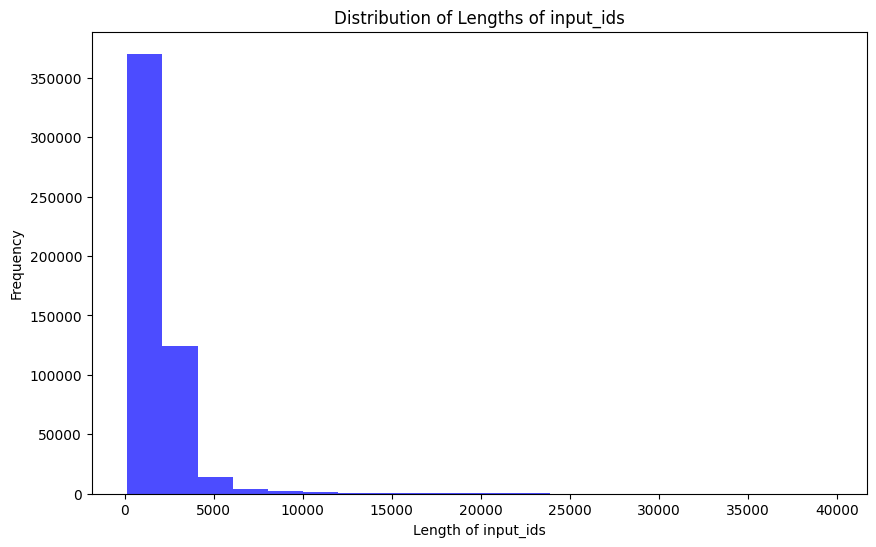

In [19]:
def plot_data_lengths(tokenized_train_dataset):
    lengths = [len(x['text']) for x in tokenized_train_dataset]
    print(len(lengths))
    print(f"Max: {max(lengths)}")
    print(f"Min: {min(lengths)}")
    print(f"Mean: {sum(lengths)/len(lengths)}")

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(data_processed)

In [ ]:
print(tokenized_chat)
tokenizer.vocab["<|assistant|>"]

tensor([[50295, 50298,   198,  7120,   389,   257,  7613, 10214,   508,   481,
          3280,   262,  2683,  1813,   284,   345, 42353, 50296,   198, 50295,
         50299,   198, 17250,   703,   389,   345, 50296,   198]])


50300